# Lens modeling of DESIJ2158+0257 with `lenstronomy`

**Author:** Fahim Rajit Hossain, Anowar Shajib
  

In [1]:
import corner
import h5py
import joblib
import lenstronomy.Util.param_util as param_util
import matplotlib.pyplot as plt
import numpy as np
import yaml
from google.colab import drive
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from light_profile import LightProfileAnalysis  # using light_profile.py

!pip install emcee
!pip install corner
!pip install cobaya
!pip install lenstronomy
!pip install ruff





%matplotlib inline

drive.mount("/content/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 965.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.0/440.0 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.0/826.0 kB 15.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
  Created wheel for cobaya: filename=cobaya-3.4.1-py3-none-any.whl size=494007 sha256=6aeebaa75a59d0e83ed1d41b31958a98e11fe44994f13a09da0c4e13caf0bc33
  Stored in directory: /root/.cache/pip/wheels/0c/83/0d/58fe2b1a72c380a15748f87392e1d40b199acb79d0d7b570bc
  Created wheel for GetDist: filename=getdist-1.4.6-py3-no

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 14.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Mounted at /content/drive


## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

In [2]:
# load HDF5 file

with h5py.File("./DESIJ2158+0257_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

# load HDF5 psf file using h5py
with h5py.File("./psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [3]:
image_size = kwargs_data["image_data"].shape
print(image_size)

(220, 220)


In [4]:
plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.grid(True, which="both", linewidth=0.5, linestyle="--", color="black")

plt.xticks(np.arange(0, 220, 20))
plt.yticks(np.arange(0, 220, 20))

plt.show()

<ipython-input-4-435cffa9e750>:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


# Creating Likelihood Mask

A likelihood mask is a tool used in statistical analysis, particularly in Bayesian statistics, to identify data points that have a strong influence on the final results of a model. It is a binary mask that identifies which data points in the model contribute to the likelihood function, and which data points do not.

In practical terms, a likelihood mask can be created by setting a threshold for the quality of the data, such as the signal-to-noise ratio or the uncertainty in the measurements. Data points that do not meet this threshold can be masked out, effectively removing them from the analysis. This can help to improve the accuracy and precision of the model by reducing the impact of noisy or unreliable data.

Likelihood masks can also be used to exclude regions of the data that are known to be problematic, such as areas affected by foreground contamination, instrumental effects, or other sources of systematic error. By excluding these regions from the analysis, the likelihood mask can help to improve the robustness and reliability of the model.

In [5]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8.5  # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3.8,
    lens_center_dec + 4.75,
    1.7,
    1.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.9,
    lens_center_dec + 8.0,
    2.8,
    2.8,
    0,
)

mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.55,
    lens_center_dec + 5.2,
    0.6,
    0.6,
    0,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 4.3,
    lens_center_dec + 2.4,
    0.8,
    0.9,
    0,
)

mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 7.5,
    lens_center_dec - 2.5,
    0.6,
    0.6,
    0,
)

mask_ext_6 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec + 4,
    0.8,
    1,
    0,
)


mask_ext_7 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec + 1.9,
    0.8,
    0.9,
    0,
)

mask_ext_8 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 4.3,
    lens_center_dec - 3,
    1.5,
    2.2,
    np.pi / 12,
)

mask_ext_9 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 0.8,
    0.25,
    0.25,
    0,
)

"""
mask_ext_8 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+2.2,
                                   lens_center_dec-3.9,
                                   1.3, 1.1, np.pi/6)

mask_ext_9 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-1.8,
                                   lens_center_dec-0.5,
                                   .7, .7, 0)
"""
mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
    * (1 - mask_ext_5)
    * (1 - mask_ext_6)
    * (1 - mask_ext_7)
    * (1 - mask_ext_8)
    * (1 - mask_ext_9)
)
mask[mask < 0] = 0


mask_img_1 = mask.reshape(num_pix, num_pix)

# Applying the Mask

<ipython-input-6-0a9bbc2dc66c>:3: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
<ipython-input-6-0a9bbc2dc66c>:15: RuntimeWarning: divide by zero encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)
<ipython-input-6-0a9bbc2dc66c>:15: RuntimeWarning: invalid value encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)


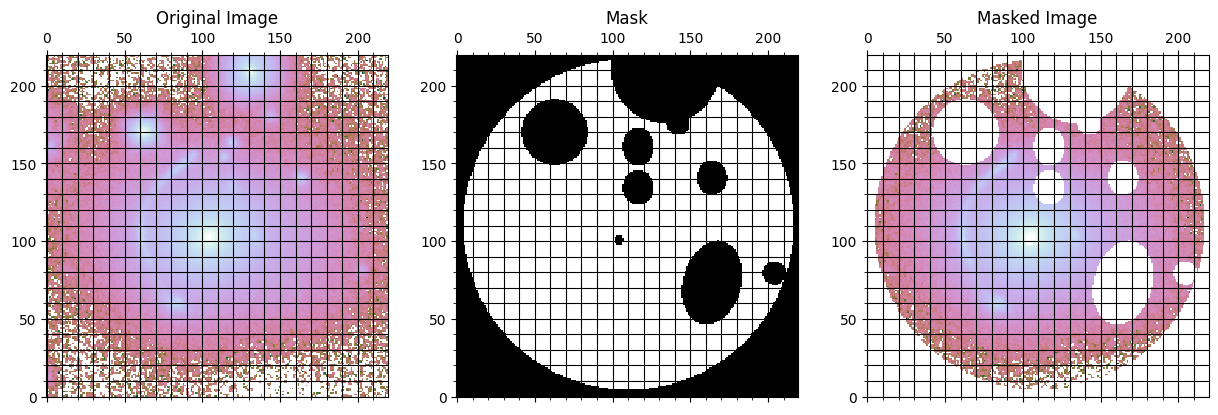

In [6]:
# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
ax1.grid(which="both", color="black")
ax1.minorticks_on()
ax1.grid(which="minor", color="black")
ax1.title.set_text("Original Image")
ax2.matshow(mask_img_1, origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.minorticks_on()
ax2.grid(which="minor", color="black")
ax2.title.set_text("Mask")
ax2.title.set_text("Mask")

image1 = np.log10(kwargs_data["image_data"] * mask_img_1)

ax3.matshow(image1, origin="lower", cmap="cubehelix")
ax3.grid(which="both", color="black")
ax3.minorticks_on()
ax3.grid(which="minor", color="black")
ax3.title.set_text("Masked Image")
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [7]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens galaxy's mass model

In [8]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# 'EPL'
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 3.32635,
        "gamma": 1.81094,
        "e1": 0.11371,
        "e2": -0.07394,
        "center_x": 0.54844,
        "center_y": -0.5563,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.3,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# add external SHEAR
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": -0.06649, "gamma2": -0.05568})
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


## Lens galaxy's light model

In [9]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# First Sersic profile
fixed_lens_light.append({"n_sersic": 1.0})  # SERSIC_ELLIPSE

kwargs_lens_light_init.append(
    {
        "R_sersic": 3.10360,
        "n_sersic": 1,
        "e1": 0.29018,
        "e2": 0.08729,
        "center_x": 0.4589,
        "center_y": -0.64499,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 9,
        "n_sersic": 1.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# Second Sersic profile

fixed_lens_light.append({"n_sersic": 4.0})  # SERSIC_ELLIPSE
kwargs_lens_light_init.append(
    {
        "R_sersic": 1.24007,
        "n_sersic": 4,
        "e1": 0.04798,
        "e2": -0.062085,
        "center_x": 0.45891,
        "center_y": -0.64499,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 4.0,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 4.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# Join centroids of the two Sersic profiles
# joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]


lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

## Source galaxy's light model

In [10]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# source galaxy's light model

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init = [
    {
        "n_sersic": 1,
        "R_sersic": 0.3190,
        "e1": -0.18573,
        "e2": 0.01174,
        "center_x": 0.97804,
        "center_y": -0.37836,
        "amp": 16,
    }
]
kwargs_source_sigma = [
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
]
kwargs_lower_source = [
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
]
kwargs_upper_source = [
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
]

# SHAPELETS profile
fixed_source.append({"n_max": 10})  # beta/50 for `SHAPLETS_POLAR_EXP`
kwargs_source_init.append(
    {"beta": 0.07730, "center_x": 0.97804, "center_y": -0.38637, "n_max": 10}
)
kwargs_source_sigma.append({"beta": 0.5, "center_x": 0.2, "center_y": 0.2, "n_max": 10})
kwargs_lower_source.append(
    {"beta": 0.01, "center_x": -10, "center_y": -10, "n_max": 10}
)
kwargs_upper_source.append({"beta": 50, "center_x": 10, "center_y": 10, "n_max": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

## combining all the above specification in the `kwargs_params` dictionary

In [11]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    # 'joint_lens_with_light': joint_lens_with_light,
}

#### Numerical settings

Applied Mask Likelihood here

In [12]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img_1]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [13]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band has independent
    # solutions of the surface brightness,
    # 'joint-linear': there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## Here the model fiting is done


In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    [
        "PSO",
        {"sigma_scale": 1.0, "n_particles": 500, "n_iterations": 100},
    ]
]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9838579089967989 reduced X^2 of best position
-14208.87592173177 log likelihood
28884 effective number of data points
[{'theta_E': 3.3365556137555292, 'gamma': 1.812559750843433, 'e1': 0.10968281001445365, 'e2': -0.07536662765611475, 'center_x': 0.5523948544113211, 'center_y': -0.5545654095844383}, {'gamma1': -0.06893935696508369, 'gamma2': -0.0565943131435121, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.33698586749247417, 'n_sersic': 1.0, 'e1': -0.20050517725023756, 'e2': 0.05000954685147067, 'center_x': 0.9945224305262544, 'center_y': -0.3789036888005893}, {'amp': 1, 'n_max': 10, 'beta': 0.07570859042834271, 'center_x': 0.9945224305262544, 'center_y': -0.3789036888005893}] source result
[{'amp': 1, 'R_sersic': 3.089096027159088, 'n_sersic': 1.0, 'e1': 0.23247086504142214, 'e2': 0.05063143220815821, 'center_x': 0.45419480273660146, 'center_y': -0.6517779200131412}, {'amp': 1, 'R_

In [ ]:
#### save model ####

kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ2158+0257_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

In [ ]:
### load model ###

load_output_path = "./DESIJ2158+0257_pso_output.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, chain_list, _ = output_
kwargs_result

{'kwargs_lens': [{'theta_E': 3.3365556137555292,
   'gamma': 1.812559750843433,
   'e1': 0.10968281001445365,
   'e2': -0.07536662765611475,
   'center_x': 0.5523948544113211,
   'center_y': -0.5545654095844383},
  {'gamma1': -0.06893935696508369,
   'gamma2': -0.0565943131435121,
   'ra_0': 0,
   'dec_0': 0}],
 'kwargs_source': [{'amp': 1,
   'R_sersic': 0.33698586749247417,
   'n_sersic': 1.0,
   'e1': -0.20050517725023756,
   'e2': 0.05000954685147067,
   'center_x': 0.9945224305262544,
   'center_y': -0.3789036888005893},
  {'amp': 1,
   'n_max': 10,
   'beta': 0.07570859042834271,
   'center_x': 0.9945224305262544,
   'center_y': -0.3789036888005893}],
 'kwargs_lens_light': [{'amp': 1,
   'R_sersic': 3.089096027159088,
   'n_sersic': 1.0,
   'e1': 0.23247086504142214,
   'e2': 0.05063143220815821,
   'center_x': 0.45419480273660146,
   'center_y': -0.6517779200131412},
  {'amp': 1,
   'R_sersic': 0.9522670206210124,
   'n_sersic': 4.0,
   'e1': 0.041643739195862006,
   'e2': -0.06

## Visualizing the fitted model with `PSO`

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.1, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result)

-0.980767966805794 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9807679668057934


/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:367: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_new.set_bad(color="k", alpha=1.0)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:368: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap fi

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


{'kwargs_lens': [{'theta_E': 3.3365556137555292, 'gamma': 1.812559750843433, 'e1': 0.10968281001445365, 'e2': -0.07536662765611475, 'center_x': 0.5523948544113211, 'center_y': -0.5545654095844383}, {'gamma1': -0.06893935696508369, 'gamma2': -0.0565943131435121, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 11.77279548545425, 'R_sersic': 0.33698586749247417, 'n_sersic': 1.0, 'e1': -0.20050517725023756, 'e2': 0.05000954685147067, 'center_x': 0.9945224305262544, 'center_y': -0.3789036888005893}, {'amp': array([ 3.97843261e+02, -1.72145533e+02, -2.59714961e+02,  3.68626283e+01,
       -9.04123365e+01,  2.11559061e+02, -1.51088395e+01,  8.43018543e+01,
        3.58780752e+01, -5.40958770e+01,  2.76029605e+01, -6.24165647e+01,
        1.02683976e+02, -1.38427385e+02,  2.79344780e+01, -1.11816809e+01,
       -1.83583318e+01, -9.79529743e+01, -6.09175802e+01,  2.05794352e+01,
       -5.32111002e+01, -1.06318157e+01,  1.25012129e+00,  1.85837382e+01,
       -2.63946200e+01,  7.30082234e+01

## *MCMC* run

In [14]:
# Define the path to the file on Google Drive
mcmc_backend = "/content/drive/MyDrive/BDLensing/mcmc_backend.h5"


fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 1,
            "n_walkers": 80,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

100%|██████████| 1/1 [02:11<00:00, 131.75s/it]


Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 1
133.67173504829407 time taken for MCMC sampling


In [15]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()
print(kwargs_result_mcmc)

{'kwargs_lens': [{'theta_E': 3.320153215565195, 'gamma': 1.9450429921005579, 'e1': 0.10950932825373803, 'e2': -0.07939955418394228, 'center_x': 0.5753859620275733, 'center_y': -0.5584211067469377}, {'gamma1': -0.0967671121284786, 'gamma2': -0.055485511690726796, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.41795495020616474, 'n_sersic': 1.0, 'e1': -0.2045045188580401, 'e2': 0.026507730415157, 'center_x': 1.093601275759061, 'center_y': -0.3557293446354735}, {'amp': 1, 'n_max': 10, 'beta': 0.08523392362781716, 'center_x': 1.093601275759061, 'center_y': -0.3557293446354735}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 3.0653376440211195, 'n_sersic': 1.0, 'e1': 0.23037257288774668, 'e2': 0.049806888976105676, 'center_x': 0.45401200091464633, 'center_y': -0.6519754153638005}, {'amp': 1, 'R_sersic': 0.942246237203613, 'n_sersic': 4.0, 'e1': 0.04285688126762268, 'e2': -0.06424555998651865, 'center_x': 0.45401200091464633, 'center_y': -0.6519754153638005}], 'kwargs_ps'

In [16]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)

(232240, 22)


## `traceplot` for MCMC chain

In [17]:
if not samples_mcmc == []:

    n_params = samples_mcmc.shape[1]
    n_walkers = 80
    n_step = int(samples_mcmc.shape[0] / n_walkers)  # 100
    n_burn = 3000

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

<ipython-input-17-add91665bff7>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2903, N_walkers: 80, N_params: 22
theta_E_lens0 3.3193 ± 0.0030
gamma_lens0 1.9432 ± 0.0244
e1_lens0 0.1082 ± 0.0034
e2_lens0 -0.0798 ± 0.0019
center_x_lens0 0.5783 ± 0.0049
center_y_lens0 -0.5575 ± 0.0023
gamma1_lens1 -0.0967 ± 0.0049
gamma2_lens1 -0.0558 ± 0.0009
R_sersic_source_light0 0.3847 ± 0.0257
e1_source_light0 -0.2069 ± 0.0152
e2_source_light0 0.0254 ± 0.0157
center_x_source_light0 1.0961 ± 0.0209
center_y_source_light0 -0.3590 ± 0.0106
beta_source_light1 0.0841 ± 0.0035
R_sersic_lens_light0 3.0725 ± 0.0096
e1_lens_light0 0.2298 ± 0.0023
e2_lens_light0 0.0501 ± 0.0024
center_x_lens_light0 0.4542 ± 0.0004
center_y_lens_light0 -0.6518 ± 0.0004
R_sersic_lens_light1 0.9423 ± 0.0075
e1_lens_light1 0.0425 ± 0.0010
e2_lens_light1 -0.0641 ± 0.0009


Number of non-linear parameters in the MCMC process: 22
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Number of evaluations in the MCMC process: 232240
232240
Shape of samples_mcmc_cut: (1840, 22)


<ipython-input-18-10bd81b11ddb>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


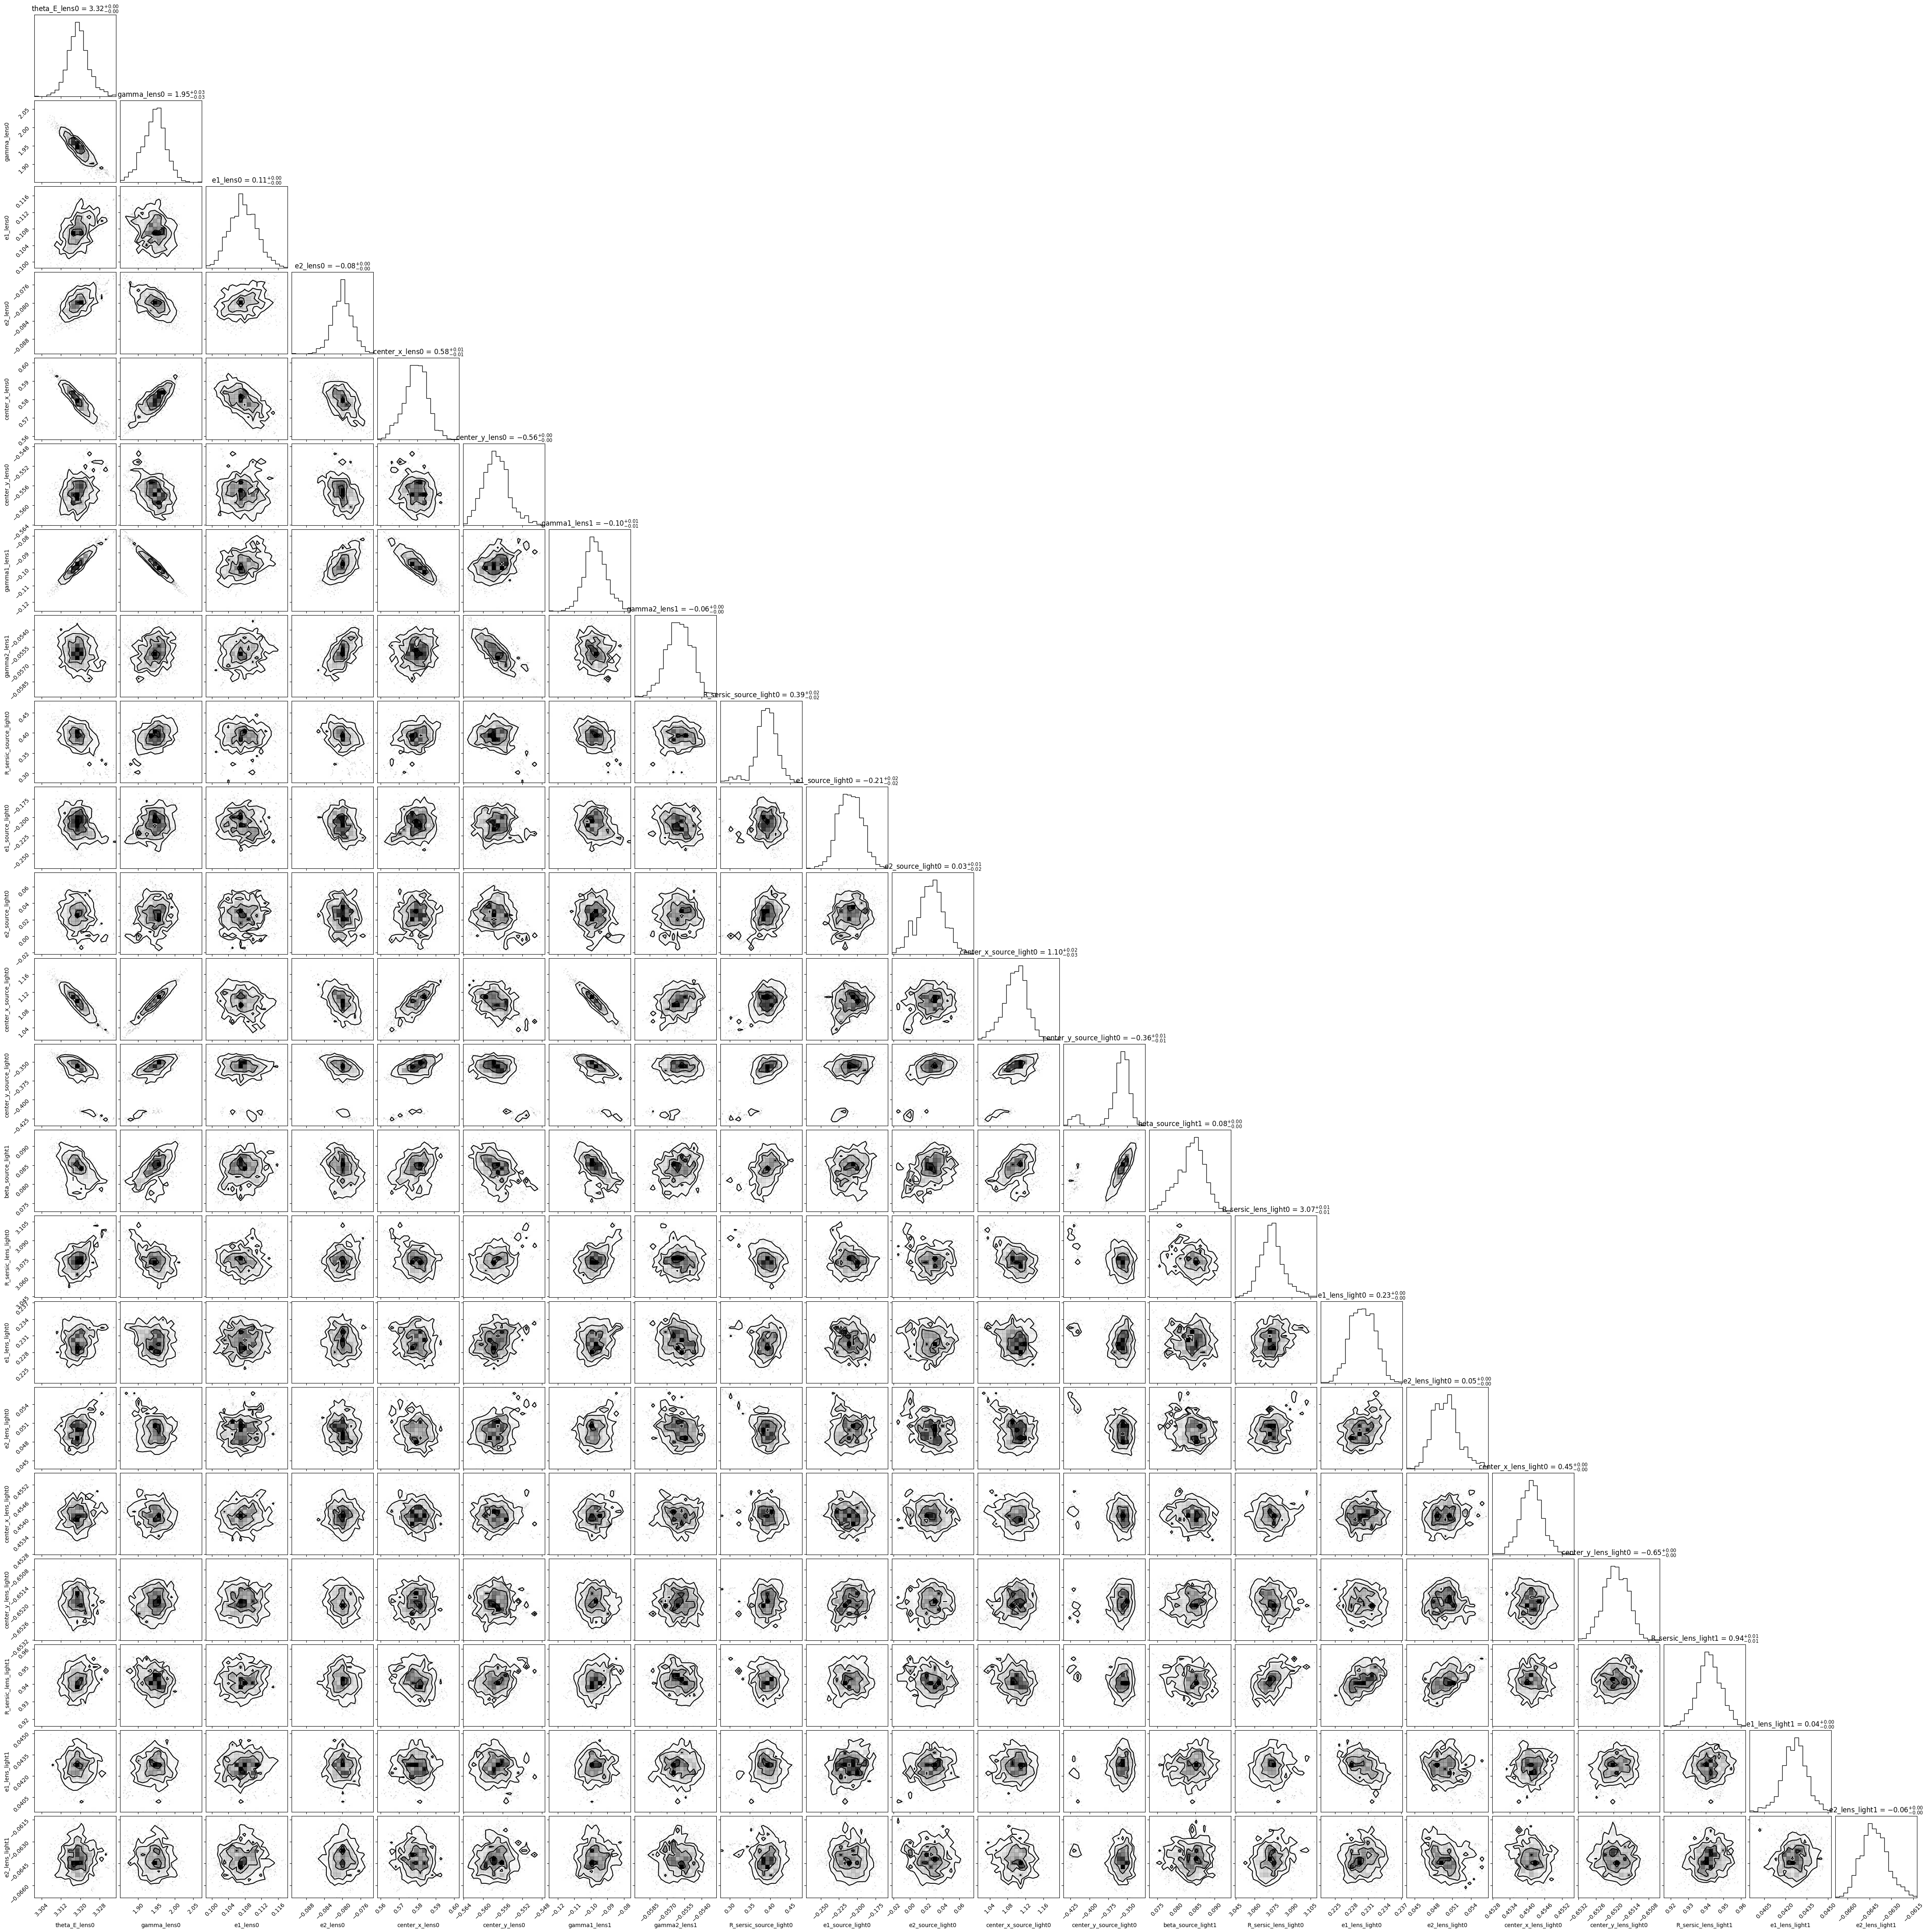

In [18]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2450
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualizing the fitted model with `MCMC`

In [19]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.1, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

-0.9798794965935252 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9798794965935231


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


{'kwargs_lens': [{'theta_E': 3.320153215565195, 'gamma': 1.9450429921005579, 'e1': 0.10950932825373803, 'e2': -0.07939955418394228, 'center_x': 0.5753859620275733, 'center_y': -0.5584211067469377}, {'gamma1': -0.0967671121284786, 'gamma2': -0.055485511690726796, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 9.570169597753145, 'R_sersic': 0.41795495020616474, 'n_sersic': 1.0, 'e1': -0.2045045188580401, 'e2': 0.026507730415157, 'center_x': 1.093601275759061, 'center_y': -0.3557293446354735}, {'amp': array([ 4.36770625e+02, -1.70093655e+02, -2.59858674e+02,  4.44168700e+01,
       -9.71030283e+01,  2.14861689e+02, -1.57200519e+01,  7.75703980e+01,
        4.34905105e+01, -4.37550038e+01,  3.51923547e+01, -5.98607925e+01,
        1.18838395e+02, -1.39256951e+02,  3.58817776e+01, -1.21108127e+01,
       -1.56311298e+01, -1.01987440e+02, -6.17911300e+01,  1.20610134e+01,
       -5.42981680e+01, -6.84281868e+00, -4.71616091e+00,  2.21573520e+01,
       -3.59263232e+01,  7.67074325e+01, -

### Comparision between Mass and Light's Ellipticity of the Lens Galaxy

In [20]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.761703432904315,
light_q: 0.6185220490640404


### save `MCMC` model ###


In [22]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 2450
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)


output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]
output_path = "./DESIJ2158+0257_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)

Number of evaluations in the MCMC process: 232240
232240
Shape of shortened_samples_mcmc: (1840, 22)


In [24]:
mcmc_output = joblib.load("DESIJ2158+0257_mcmc_output.joblib")
param_mcmc = mcmc_output[1][4]
print(param_mcmc)

['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']


In [25]:
# The list of parameters to be included in the yaml file without conversion

list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E_lens0': [3.3190189776229966, 0.0042112190479692835, 0.0039057799699309115], 'gamma_lens0': [1.9460113129666945, 0.026606419659995995, 0.033318243945533954], 'center_x_lens0': [0.5792620772396988, 0.0058442547341962525, 0.006456243829912389], 'center_y_lens0': [-0.5573944546716258, 0.002405730828807129, 0.0024997777709081515], 'center_x_lens_light0': [0.4541393982818378, 0.0003615628422861672, 0.00036460671054944216], 'center_y_lens_light0': [-0.6519306723247364, 0.00043504466373756046, 0.0004111803803922287]}


In [26]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "gamma_shear",
    "phi_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E_lens0': [3.3190189776229966, 0.0042112190479692835, 0.0039057799699309115], 'gamma_lens0': [1.9460113129666945, 0.026606419659995995, 0.033318243945533954], 'center_x_lens0': [0.5792620772396988, 0.0058442547341962525, 0.006456243829912389], 'center_y_lens0': [-0.5573944546716258, 0.002405730828807129, 0.0024997777709081515], 'center_x_lens_light0': [0.4541393982818378, 0.0003615628422861672, 0.00036460671054944216], 'center_y_lens_light0': [-0.6519306723247364, 0.00043504466373756046, 0.0004111803803922287], 'phi_mass': [-0.32022823223854024, 0.010989574372823108, 0.010436635888173007], 'q_mass': [0.7636169303200093, 0.003776798319861552, 0.0040897479356099], 'gamma_shear': [-1.3102739855610182, 0.0177620198636117, 0.0140016406393908], 'phi_shear': [0.11239001003540977, 0.005023200092038119, 0.005679134828605159], 'phi_light': [0.10673328539957615, 0.003959883786227955, 0.0038993961976350744], 'q_light': [0.6190617579883588, 0.002957472637172387, 0.003433848866535416]}


### Half-light radius calculation

In [27]:
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.01, grid_num=10 / 0.01
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius

print(parameter_values)

Half-light radius: 1.2150074399772208
{'theta_E_lens0': [3.3190189776229966, 0.0042112190479692835, 0.0039057799699309115], 'gamma_lens0': [1.9460113129666945, 0.026606419659995995, 0.033318243945533954], 'center_x_lens0': [0.5792620772396988, 0.0058442547341962525, 0.006456243829912389], 'center_y_lens0': [-0.5573944546716258, 0.002405730828807129, 0.0024997777709081515], 'center_x_lens_light0': [0.4541393982818378, 0.0003615628422861672, 0.00036460671054944216], 'center_y_lens_light0': [-0.6519306723247364, 0.00043504466373756046, 0.0004111803803922287], 'phi_mass': [-0.32022823223854024, 0.010989574372823108, 0.010436635888173007], 'q_mass': [0.7636169303200093, 0.003776798319861552, 0.0040897479356099], 'gamma_shear': [-1.3102739855610182, 0.0177620198636117, 0.0140016406393908], 'phi_shear': [0.11239001003540977, 0.005023200092038119, 0.005679134828605159], 'phi_light': [0.10673328539957615, 0.003959883786227955, 0.0038993961976350744], 'q_light': [0.6190617579883588, 0.0029574726

In [35]:
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "/content/drive/MyDrive/BDLensing/DESIJ2158+0257_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")
print(parameter_values)

YAML file '/content/drive/MyDrive/BDLensing/DESIJ2158+0257_point_estimates.yml' created successfully.
{'theta_E_lens0': [3.3190189776229966, 0.0042112190479692835, 0.0039057799699309115], 'gamma_lens0': [1.9460113129666945, 0.026606419659995995, 0.033318243945533954], 'center_x_lens0': [0.5792620772396988, 0.0058442547341962525, 0.006456243829912389], 'center_y_lens0': [-0.5573944546716258, 0.002405730828807129, 0.0024997777709081515], 'center_x_lens_light0': [0.4541393982818378, 0.0003615628422861672, 0.00036460671054944216], 'center_y_lens_light0': [-0.6519306723247364, 0.00043504466373756046, 0.0004111803803922287], 'phi_mass': [-0.32022823223854024, 0.010989574372823108, 0.010436635888173007], 'q_mass': [0.7636169303200093, 0.003776798319861552, 0.0040897479356099], 'gamma_shear': [-1.3102739855610182, 0.0177620198636117, 0.0140016406393908], 'phi_shear': [0.11239001003540977, 0.005023200092038119, 0.005679134828605159], 'phi_light': [0.10673328539957615, 0.003959883786227955, 0.00

In [36]:
# Read the YAML file using safe_load

with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 13
{'R_eff_light': 1.2150074399772208, 'center_x_lens0': [0.5792620772396988, 0.0058442547341962525, 0.006456243829912389], 'center_x_lens_light0': [0.4541393982818378, 0.0003615628422861672, 0.00036460671054944216], 'center_y_lens0': [-0.5573944546716258, 0.002405730828807129, 0.0024997777709081515], 'center_y_lens_light0': [-0.6519306723247364, 0.00043504466373756046, 0.0004111803803922287], 'gamma_lens0': [1.9460113129666945, 0.026606419659995995, 0.033318243945533954], 'gamma_shear': [-1.3102739855610182, 0.0177620198636117, 0.0140016406393908], 'phi_light': [0.10673328539957615, 0.003959883786227955, 0.0038993961976350744], 'phi_mass': [-0.32022823223854024, 0.010989574372823108, 0.010436635888173007], 'phi_shear': [0.11239001003540977, 0.005023200092038119, 0.005679134828605159], 'q_light': [0.6190617579883588, 0.002957472637172387, 0.003433848866535416], 'q_mass': [0.7636169303200093, 0.003776798319861552, 0.0040897479356099], 'theta_E_lens0': [3.319

theta_E, gamma, q_mass, phi_mass, center_x_mass, center_y_mass, gamma_shear, phi_shear, R_eff_light, q_light, phi_light, center_x_light, center_y_light, Sigma_10, Sigma_10_flux_selected, Sigma_20, Sigma_20_flux_selected.